# A Similarity Loss function on the ImageNet and WordNet Hierarchy.

#### Summary

The [ImageNet](http://www.image-net.org/) database is not only large annotated image database from where to train the famous [VGG16](https://arxiv.org/abs/1409.1556) deep neural network, but it is also structured according to the [WordNet](https://wordnet.princeton.edu/) **hierarchy**, a graph structured word database.

We can navigate the hierarchy using the NLTK library in an object oriented manner, which also provides different measures of **similarity**.
After an overview, we provide a wrapper method to **download images from a word**, with an optional number limit, mapping WordNet to ImageNet.

Then, we implement custom  **similarity loss functions** and compare the classification performance to state of the art for a dataset made of images of "street", "building", "glacier", "mountain" and "seashore".

#### Main conclusions

The results are very similar. As an advantage, our loss functions mirror better the behaviour of validation accuracy than cross entropy. However, they are harder to optimise.

Perhaps, introducing class similarity or distance information is more relevant when it is not visible from data, but as **external information**. For example, in quality control, if we penalize asymetrically the confusion of different pairs of classes according to some economic cost to it that is not part of learnable data, this proposal could pose a strategic advantage. Here, however, the real similarity between images is already reflected in the confusion matrix. After all, the similarity between classes is subjective.

#### Navigating the WordNet structure with  NLTK

In [ ]:
import nltk
from nltk.corpus import wordnet

nltk.download('wordnet')
dog = wordnet.synsets('dog')[0]
cat = wordnet.synsets('domestic_cat')[0]

print('\n definition')
print(dog.definition())
print('\n identifiers')
print(cat.pos(), cat.offset())
print('\n immediate parent classes')
print(cat.hypernyms())
print(dog.hypernyms())
print('\n lower common parent class of cat and dog')
print(cat.lowest_common_hypernyms(dog))
print('\n immediate child classes')
print(cat.hyponyms())
print('\n full sub-hierarchy')
def print_all_children(node, depth=0):
    print('\t'*depth, node)
    for child in node.hyponyms():
        print_all_children(child, depth=depth+1)
print_all_children(cat)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!

 definition
a member of the genus Canis (probably descended from the common wolf) that has been domesticated by man since prehistoric times; occurs in many breeds

 identifiers
n 2121808

 immediate parent classes
[Synset('cat.n.01'), Synset('domestic_animal.n.01')]
[Synset('canine.n.02'), Synset('domestic_animal.n.01')]

 lower common parent class of cat and dog
[Synset('carnivore.n.01')]

 immediate child classes
[Synset('abyssinian.n.01'), Synset('alley_cat.n.01'), Synset('angora.n.04'), Synset('burmese_cat.n.01'), Synset('egyptian_cat.n.01'), Synset('kitty.n.04'), Synset('maltese.n.03'), Synset('manx.n.02'), Synset('mouser.n.01'), Synset('persian_cat.n.01'), Synset('siamese_cat.n.01'), Synset('tabby.n.01'), Synset('tabby.n.02'), Synset('tiger_cat.n.02'), Synset('tom.n.02'), Synset('tortoiseshell.n.03')]

 full sub-hierarchy
 Synset('domestic_cat.n.01')
	 Synset('abyss

#### ImageNet API download wrapper from word

**Description of our download wrapper**:
- given a search string, we look it up on the WordNet vocabulary, replacing spaces by underscores
- we get its POS (only nouns for now, so always 'n') and OFFSET id,  which uniquely identifies the synset (synonym set), padded with zeros on the left until length 8, and concatenate POS and OFFSET to get the *wnid* identifier for ImageNet
- we download a list of image urls with the API command *http://www.image-net.org/api/text/imagenet.synset.geturls?wnid={wnid}*
- we create a folder for the word, where we store the images, inside the specified output directory, which is the current one by default. If the folder exists, we do not download again the existing images, so if interrupted, the method can be called again efficiently.

In [ ]:
from urllib.request import urlopen, urlretrieve
import os

import cv2
import numpy as np

def get_urls(wnid):
    for line in urlopen(f'http://www.image-net.org/api/text/imagenet.synset.geturls?wnid={wnid}'):
        yield line.decode('utf-8').rstrip()

def pad_offset(offset):
    return str(offset).zfill(8)

def url_retrieve_timeout(url, fpath, timeout=10):
    resp = urlopen(url,timeout=timeout)
    
    #check it can be read
    img_str=resp.read()
    nparr = np.frombuffer(img_str, np.uint8)
    img_np = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    
    with open(fpath, 'wb') as f:
        f.write(resp.read())

def download_imgs(class_name, max_n=None, debug=True, output_dir ="./"):
    """Download images from ImageNet into a folder with the class name inside of the specified or current directory."""
    class_name=class_name.replace(' ','_')
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    class_dir = os.path.join(output_dir , class_name)
    pre_existing=[]
    if not os.path.exists(class_dir):
        os.mkdir(class_dir)
    else:
        pre_existing = os.listdir(class_dir)
        if pre_existing:
            print(len(pre_existing), 'already downloaded images')
    syns=wordnet.synsets(class_name)[0]
    pos, offset = syns.pos(), syns.offset()
    offset = pad_offset(offset)
    wnid=f'{pos}{offset}'
    success_count=1
    fail_count=1
    urls = list(get_urls(wnid))
    if debug:
        print(len(urls), 'urls')
    for url in urls:
        if max_n and success_count > max_n:
            break
        if debug:
            print(url)
        img_name=url.split('/')[-1]
        if img_name in pre_existing:
            if debug:
                print('already downloaded', img_name)
            success_count+=1
            continue
        try:
            fpath=f'{class_dir}/{img_name}'
            # urlretrieve(url, fpath)
            url_retrieve_timeout(url, fpath, timeout=10)
            #check opencv can open it
            cv2.imread(fpath)
            success_count+=1
        except Exception as e:
            fail_count+=1
            if debug:
                print(e)
    print(success_count-1, 'downloaded')
    print(fail_count-1, 'failed')

Loading this will take approx 2h! Skip to loading from google drive

In [ ]:
max_n=1000

download_imgs('glacier', max_n, debug=True, output_dir='images')
download_imgs('mountain',max_n, debug=True, output_dir='images')
download_imgs('seashore',max_n, debug=True, output_dir='images')
download_imgs('street',  max_n, debug=True, output_dir='images')
download_imgs('building',max_n, debug=True, output_dir='images')

In [ ]:
def folder_report(path='.'):
    result={'name':path,'size':0,'n_files':0,'n_folders':0, 'folders':[]}
    for entry in os.scandir(path):
        if entry.is_file():
            result['size'] += entry.stat().st_size
            result['n_files'] += 1
        elif entry.is_dir():
            result['n_folders'] += 1
            sub_result = folder_report(entry.path)
            result['size'] += sub_result['size']
            result['folders'].append(entry.name)
    print(result)
    return result

result=folder_report('images')
print(result['size']/(1024*1024), 'MB')

{'name': 'images/glacier', 'size': 47432254, 'n_files': 724, 'n_folders': 0, 'folders': []}
{'name': 'images/building', 'size': 51141195, 'n_files': 932, 'n_folders': 0, 'folders': []}
{'name': 'images/seashore', 'size': 49039013, 'n_files': 708, 'n_folders': 0, 'folders': []}
{'name': 'images/street', 'size': 78128986, 'n_files': 1000, 'n_folders': 0, 'folders': []}
{'name': 'images/mountain', 'size': 94739876, 'n_files': 994, 'n_folders': 0, 'folders': []}
{'name': 'images', 'size': 320481324, 'n_files': 0, 'n_folders': 5, 'folders': ['glacier', 'building', 'seashore', 'street', 'mountain']}
305.6348075866699 MB


This took long...save results to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import shutil
data_dir = 'gdrive/My Drive/Colab Notebooks/for the show/Hierarchy and Distance/data'
shutil.move('images', data_dir)

os.listdir(data_dir)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


['street', 'building', 'glacier', 'mountain', 'seashore', 'X.npy', 'Y.npy']

Save data as X,y numpy arrays.

In [ ]:
import numpy as np

X=[]
Y=[]
for y,folder in enumerate(os.listdir(data_dir)):
    print(folder)
    folder_dir=os.path.join(data_dir, folder)
    for fname in os.listdir(folder_dir):
        fpath=os.path.join(folder_dir, fname)
        # print(fpath)
        x=cv2.imread(fpath)#BGR
        if x is None:
            print(fpath,'is None')
            continue
        x=cv2.resize(x,(224,224))
        X.append(x)
        Y.append(y)

X=np.array(X)[:,:,::-1]
Y=np.array(Y)
np.save(data_dir+'X.npy', X)
np.save(data_dir+'Y.npy', Y)

X.shape, Y.shape

((3999, 224, 224, 3), (3999, 5))

### Load data from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

data_dir = 'gdrive/My Drive/Colab Notebooks/for the show/Hierarchy and Distance/data/'
import numpy as np

X=np.load(data_dir+'X.npy')
Y=np.load(data_dir+'Y.npy')
classes=classes=['street', 'building', 'glacier', 'mountain', 'seashore']

from keras.utils.np_utils import to_categorical
Y=to_categorical(Y)
#bgr to rgb
X=X[:,:,:,::-1]
X.shape, Y.shape, classes, Y.sum(axis=0)

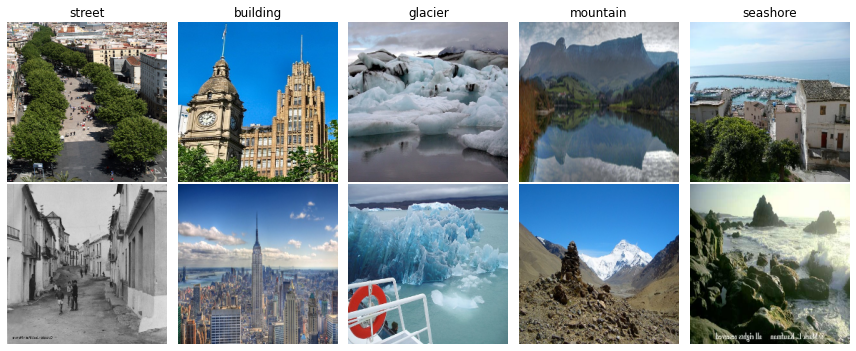

In [ ]:
from matplotlib import pyplot as plt

nrows=2
fig, axs = plt.subplots(nrows=nrows, ncols=len(classes), figsize=(12,5))
for row in axs:
    for col in row:
      col.axis('off')
for i, c in enumerate(classes):
    idx=np.where(Y.argmax(axis=1)==i)[0]
    for row in range(nrows):
        i0 =  idx[row]
        x = X[i0]
        ax=axs[row,i]
        ax.imshow(x)
        if row==0:
            ax.set_title(c)
fig.subplots_adjust(hspace = 0)
fig.tight_layout()
fig.show()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [ ]:
import nltk
from nltk.corpus import wordnet
nltk.download('wordnet')
# ic=wordnet.ic(wordnet)
nltk.download('brown')
from nltk.corpus import brown
ic=wordnet.ic(brown)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


#### Similarity Measures available on NLTK

The semantic measures *Shortest Path*, *Leacock-Chodorow* and *Wu-Palmer* are purely based on the **graph geometry** of nodes, ie words,  $s_1$, $s_2$:
- lowest common hypernym aka subsumer $s$
- depth in the taxonomy $d$
- shortest path between them $p$

The semantic measures by *Resnik*, *Lin* and *Jiang-Conrath* incorporate **corpus statistics**
- relative word frequency $P$ of node, including subnodes, inside the corpus
  - Information Content $IC=-ln P$

Here is a summary of the similarity methods:
- *Shortest Path* $$path = \frac{1}{1+p}$$

- *Leacock-Chodorow* $$lch = ln\left(\frac{p}{2d(s)}\right)$$

- *Wu-Palmer* $$wup = \frac{2 d(s)}{d(s_1)+d(s_2)}$$

- *Resnik* $$res = IC(s)$$

- *Lin* $$lin = \frac{2 IC(s)}{IC(s_1) + IC(s_2)}$$

- *Jiang-Conrath* $$jcn = \frac{1}{IC(s_1) + IC(s_2) - 2  IC(s)}$$

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


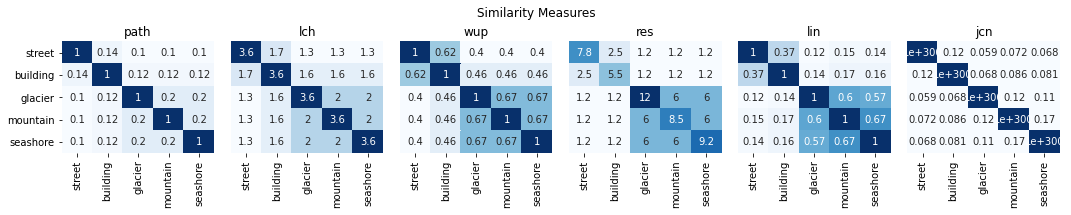

In [ ]:
import pandas as pd
import seaborn as sns

def similarity_matrix(classes, similarity = wordnet.path_similarity):
  n=len(classes)
  G=pd.DataFrame(index=classes, columns=classes)
  class_synsets={}
  for class_ in classes:
    class_synsets[class_]=wordnet.synsets(class_)[0]
  for c1,s1 in class_synsets.items():
    for c2, s2 in class_synsets.items():
      s=similarity(s1,s2)
      # s=s1.lin_similarity(s2, ic)
      G[c1][c2]=s
  return G

similarity_measures = {
    'path':wordnet.path_similarity, 'lch':wordnet.lch_similarity, 'wup':wordnet.wup_similarity,
    'res': lambda s1, s2: wordnet.res_similarity(s1,s2,ic),
    'lin': lambda s1, s2: wordnet.lin_similarity(s1,s2,ic),
    'jcn': lambda s1, s2: wordnet.jcn_similarity(s1,s2,ic),
}

nrows=1
fig, axs = plt.subplots(nrows=nrows, ncols=len(similarity_measures), figsize=(15,3),squeeze=False)
fig.suptitle('Similarity Measures')
for i, (k,similarity_measure) in enumerate(similarity_measures.items()):
    ax=axs[0,i]
    G=similarity_matrix(classes, similarity_measure)
    ax = sns.heatmap(G.astype(float), cmap='Blues',annot=True, ax=ax, cbar=False,yticklabels='auto' if i==0 else False)
    ax.set_title(k)
fig.subplots_adjust(wspace = 0)
fig.tight_layout()
fig.subplots_adjust(top=0.82)
fig.show()

Select Lin for presenting the clearest groups and good behaviour, followed by WuP.

Define distance as $D=1-G$, where $G$ is the similarity or *Gram* matrix.

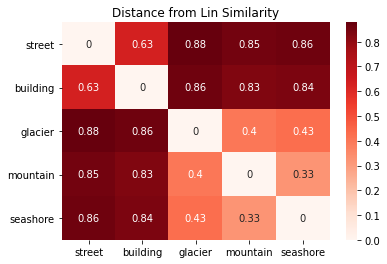

In [ ]:
G=similarity_matrix(classes, similarity_measures['lin'])
D=1-G
ax = sns.heatmap(D.astype(float), cmap='Reds',annot=True)
_=ax.set_title('Distance from Lin Similarity')

Define our custom similarity loss variants, assuming similarities and distances range [0,1] for simplicity, and $p,q$ represent probability vectors of real and predicted classes:

- Dot product loss with custom distances
$$\mathcal{L}_{dot}(p,q)=p^T D q = 1- p^T G q $$

- Dot product loss with symmetric distances
$$\mathcal{L}_{symdot}(p,q)=1-p^T q$$

- Cosine loss (dividing by norms) with custom distances
$$\mathcal{L}_{cos}(p,q)=1-\frac{p^T G q}{\sqrt{p^T G p} \hspace{3mm} \sqrt{q^T G q}}$$

- Cosine loss (dividing by norms) with symmetric distances
$$\mathcal{L}_{symcos}(p,q)=1-\frac{p^T q}{\sqrt{p^T p} \hspace{3mm} \sqrt{q^T q}}$$

In [ ]:
import keras.backend as K
import numpy as np

def batch_bidot(p_batch,q_batch,M):
    """Compute p^T M q for every vector in the batches of p_batch and q_batch."""
    return K.batch_dot(K.dot(p_batch, M),q_batch)

def create_dot_loss(D):
    """p^T D q Dot Loss: Non Normalized version of cosine loss, with custom class distances D=1-G.
    G being the Gram (Similarity) Matrix."""
    D = K.constant(np.array(D))
    def dot(p, q):
        return K.mean(batch_bidot(p,q,D))
    return dot
dloss = create_dot_loss(D)

def symdot(p,q):
  """1-p^T q Dot Loss with symmetric class distances, ie D=1-I, ie identity Gram Matrix G=I."""
  return 1-K.mean(K.batch_dot(p,q))

def create_cosine_loss(D):
    """p^T G q / ((p^T G p) (q^T G q))^(1/2) Cosine loss with custom class distances D=1-G.
     G being the Gram (Similarity) Matrix."""
    G=K.constant(1-np.array(D))
    def cos(p, q):
        p_norm = batch_bidot(p,p,G)**(1/2)
        q_norm = batch_bidot(q,q,G)**(1/2)
        cos_sim=batch_bidot(p,q,G)/(q_norm*p_norm)
        return 1-K.mean(cos_sim)
    return cos
closs = create_cosine_loss(D)

def symcos(p,q):
  """1-p^T q/(|p||q|) Typical cosine loss for symmetric class distances."""
  return 1-K.mean(K.batch_dot(p,q))

Define our model as the VGG16 network with style transfer and trainable top layers.

In [ ]:
from keras.applications import VGG16
from keras.models import Sequential, load_model, Model
from keras.layers import Dense,Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam

target_size=224
channels=3

def VGG_categorical(input_shape, classes):
    # Initialize VGG16 using pre-trained weights on imagenet and use transfer learning for re-training the last layers
    model = VGG16(weights='imagenet', include_top=False,input_shape=input_shape)
    # Freeze all the layers except for the last ones, so that we can retrain the last ones.
    # for layer in model.layers[:-4]:
    for layer in model.layers[:-4]:
        layer.trainable = False
    # Adding our new layers    
    top_layers = model.output
    top_layers = Flatten(input_shape=model.output_shape[1:])(top_layers)
    top_layers = Dense(500, kernel_initializer='random_uniform', activation="relu")(top_layers)
    top_layers = Dropout(0.4)(top_layers)
    top_layers = Dense(50, kernel_initializer='random_uniform', activation="relu")(top_layers)
    top_layers = Dropout(0.3)(top_layers)
    top_layers = Dense(classes, activation="softmax")(top_layers)

    # Add top layers on top of freezed (not re-trained) layers of VGG16
    model = Model(inputs = model.input, outputs = top_layers)
    return model

model = VGG_categorical((target_size,target_size,channels),classes=len(classes))
# model.summary()

58892288/58889256 [==============================] - 0s 0us/step


Define some plotting utils

In [ ]:
import pandas as pd

def plot_history(history):
  """Plot a metrics and its validation in the same color, validation in dashed style, y axis ranging (0,1)"""
  history=pd.DataFrame(history)
  history=history.reset_index().rename({'index':'epochs'},axis='columns').set_index('epochs')
  ax=None
  for i,loss in enumerate(history):
    if 'val_' in loss:
      continue
    ax=history[[loss,'val_'+loss]].plot(figsize=(10,6),grid=True,ax=ax,ylim=(0,1.01), style=['-','--'], color=[f'C{i}',f'C{i}'])

def plot_model_history(model):
  plot_history(model.history.history)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
        
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
    disp = disp.plot(include_values=True,cmap='Blues')
    ax=disp.ax_
    for label in ax.get_xticklabels():
      label.set_rotation(45)
      label.set_ha('right')
    return ax

def plot_model_confusion_matrix(model,X,y,classes):
  p = model.predict(X)
  return plot_confusion_matrix(y.argmax(axis=1), p.argmax(axis=1), classes)

def evaluate_df(model,X_train,y_train,X_test,y_test):
  """Gather results of metrics in a dataframe."""
  res=pd.DataFrame()
  res_valid=model.evaluate(X_test,y_test,verbose=0)
  res['valid']=pd.Series(data=res_valid,index=model.metrics_names)
  res_train=model.evaluate(X_train,y_train,verbose=0)
  res['train']=pd.Series(data=res_train,index=model.metrics_names)
  return res.T

In [ ]:
def plot_all_confused(model,X,y):
  p=model.predict(X)
  p_hard=p.argmax(axis=1)
  y_hard=y.argmax(axis=1)

  for k, (yk, pk) in enumerate(zip(y_hard,p_hard)):
    if yk!=pk:
      plt.imshow(X[k])
      plt.title(classes[yk]+'_'+classes[pk])
      plt.show()

def confusion_collage(model, X, y):
  """Plot a grid with an example of wrong predictions, if any."""
  p=model.predict(X)
  p_hard=p.argmax(axis=1)
  y_hard=y.argmax(axis=1)

  n=len(classes)
  fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(6,6))
  for row in axs:
    for col in row:
      col.axis('off')
  for i,cy in enumerate(classes):
    yi=np.where(y_hard==i)[0]
    pyi=p_hard[yi]
    for j,cp in enumerate(classes):
      if i==0:
        axs[i,j].set_title(cp)  
      if j==i:
        continue
      pjyi=np.where(pyi==j)[0]
      if len(pjyi):
        #plot the image with greatest probability of wrong class j
        idx=yi[pjyi]
        k=p[:,j][idx].argmax()
        x=X[idx[k]]
        axs[i,j].imshow(x)
  fig.tight_layout()
  return fig, axs
# fig,axs=confusion_collage(model,X_test,y_test)

Define a training procedure that incrementally decreases the learning rate.

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from IPython.display import clear_output

def zoom_in_fit(model, loss, monitor, metrics, Optimizer, X_train, y_train, X_test, y_test):
  """Fit for decreasing learning rates with early stopping on loss and model checkpoint on monitoring measure.
  Plot the learning curve, the confusing matrix and our "confusion collage" when finished."""
  # checkpoint
  loss_name=loss.__name__ if callable(loss) else loss
  monitor_name = monitor.__name__ if callable(monitor) else monitor
  fname=f'{loss_name}_loss_{monitor_name}_monitor_weights.hdf5'
  monitor_checkpoint = ModelCheckpoint(fname, monitor=monitor, verbose=1, save_best_only=True, mode='auto')
  early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto',restore_best_weights=True)
  history={}
  for lr in [1e-5,1e-6,5e-7]:
    model.compile(loss=loss, optimizer=Optimizer(lr), metrics=metrics)
    hist=model.fit(X_train,y_train,
          validation_data=(X_test, y_test),
          batch_size=32,
          epochs=100,
          verbose=1,
          callbacks=[monitor_checkpoint,early_stop]
          )
    clear_output(wait=True)
    hist=hist.history
    plot_history(hist);plt.show()
    #combine history from different fit calls
    for k in hist:
      if k not in history:
        history[k]=[]
      history[k] += hist[k]
  clear_output(wait=True)

  #plot whole history
  plot_history(history)
  plt.title(f'{loss_name} learning curve')

  #display validation and train metrics nicely
  model.load_weights(fname)
  display(evaluate_df(model,X_train,y_train,X_test,y_test).round(4))

  ax=plot_model_confusion_matrix(model,X_test,y_test,classes)
  plt.title('Validation Confusion Matrix')

  fig,axs=confusion_collage(model,X_test,y_test)

  return history

Compare the result of fitting on our loss functions with the state of the art loss combination of categorical crossentropy loss and accuracy monitoring.

Set the same weights for all training processes.

In [ ]:
model = VGG_categorical((target_size,target_size,channels),classes=len(classes))
w0=model.get_weights()

,loss,accuracy,dot,symdot,cos,symcos
valid,0.8623,0.8875,0.0632,0.1200,0.0551,0.1200
train,0.0007,0.9997,0.0003,0.0004,0.0002,0.0004


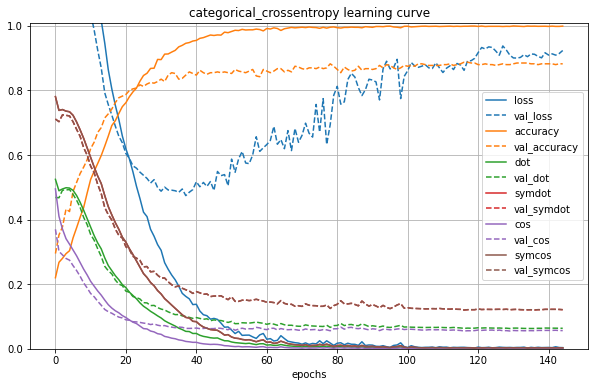

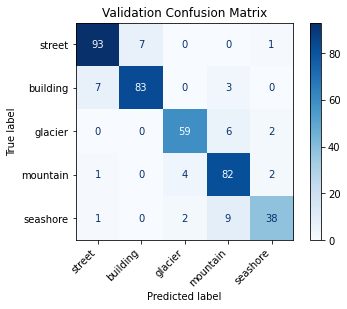

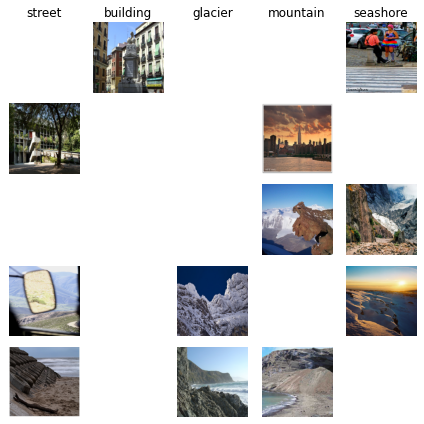

In [ ]:
#State of the Art
model.set_weights(w0)
history=zoom_in_fit(model, 'categorical_crossentropy', 'val_accuracy', ['accuracy',dloss,symdot,closs,symcos], Adam, X_train, y_train, X_test, y_test)

,loss,accuracy,dot,symdot,symcos,categorical_crossentropy
valid,0.0618,0.885,0.0607,0.1110,0.1110,7.3528
train,0.0185,0.965,0.0188,0.0352,0.0352,3.5046


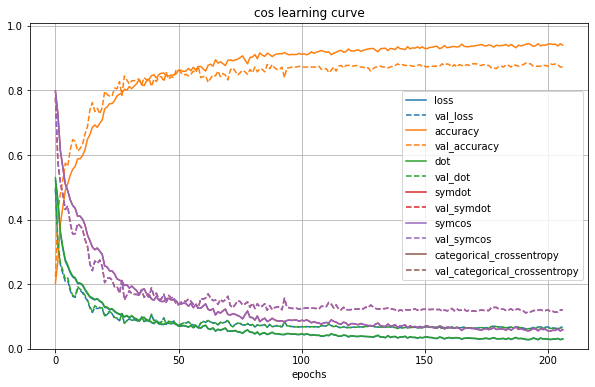

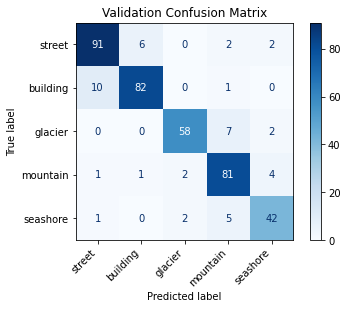

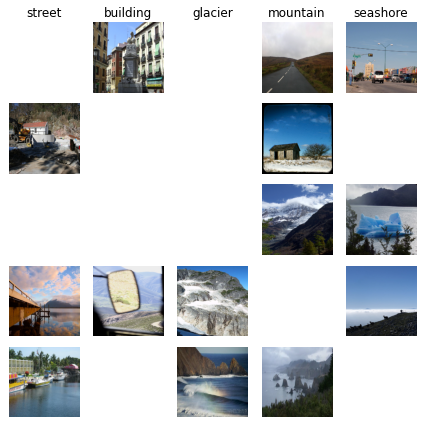

In [ ]:
#asymmetric, normalized
model.set_weights(w0)
history=zoom_in_fit(model, closs, 'val_loss', ['accuracy',dloss, symdot,symcos,'categorical_crossentropy'], Adam, X_train, y_train, X_test, y_test)

,loss,accuracy,symdot,cos,symcos,categorical_crossentropy
valid,0.0654,0.8725,0.1235,0.0639,0.1235,10.1424
train,0.0426,0.9164,0.0839,0.0423,0.0839,6.9556


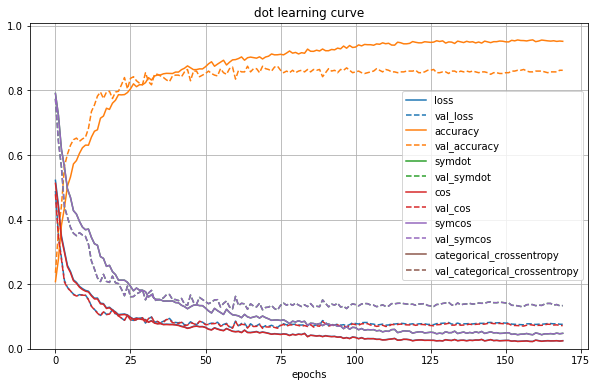

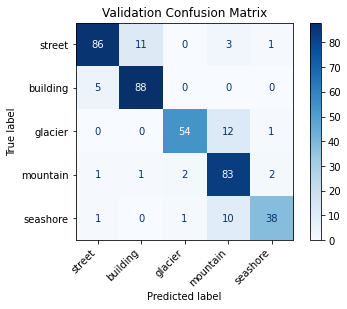

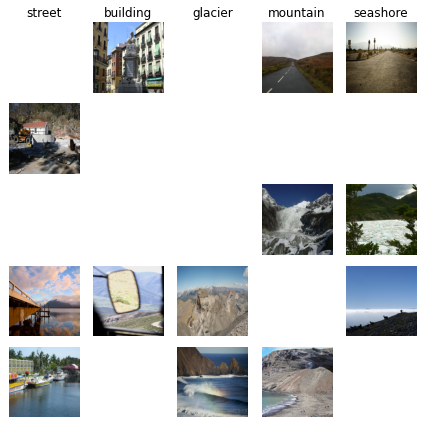

In [ ]:
#asymmetric, non normalized
model.set_weights(w0)
history=zoom_in_fit(model, dloss, 'val_loss', ['accuracy',symdot,closs,symcos,'categorical_crossentropy'], Adam, X_train, y_train, X_test, y_test)

,loss,accuracy,dot,symdot,cos,categorical_crossentropy
valid,0.1127,0.8875,0.0608,0.1131,0.0599,8.4698
train,0.0435,0.9567,0.0257,0.0439,0.0255,4.2470


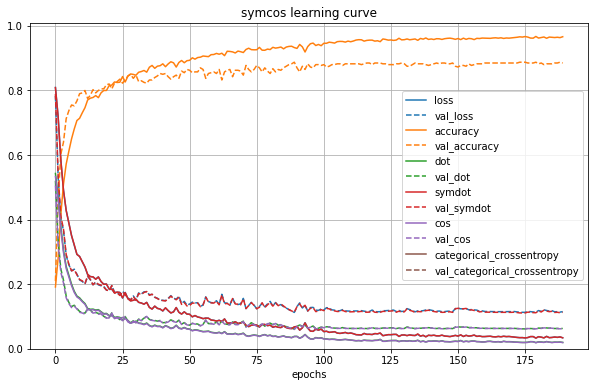

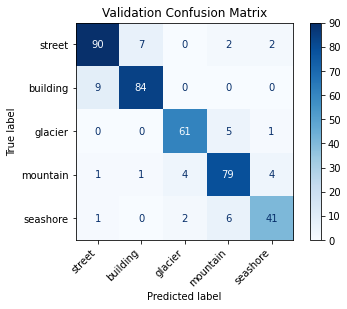

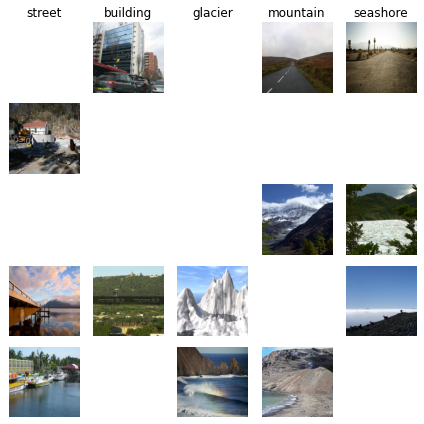

In [ ]:
#symmetric, normalized
model.set_weights(w0)
history=zoom_in_fit(model, symcos, 'val_loss', ['accuracy',dloss, symdot, closs,'categorical_crossentropy'], Adam, X_train, y_train, X_test, y_test)

,loss,accuracy,dot,cos,symcos,categorical_crossentropy
valid,0.1087,0.8950,0.0592,0.0579,0.1069,8.8539
train,0.0428,0.9572,0.0244,0.0241,0.0429,3.7033


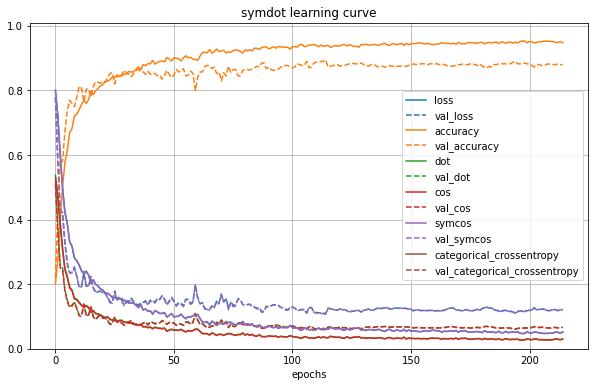

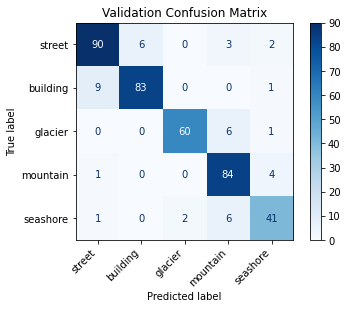

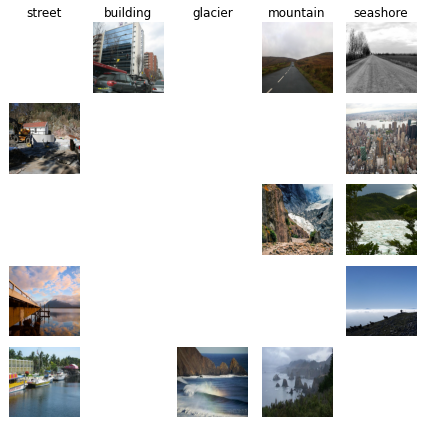

In [ ]:
#symmetric, non normalized
model.set_weights(w0)
history=zoom_in_fit(model, symdot, 'val_loss', ['accuracy',dloss, closs,symcos,'categorical_crossentropy'], Adam, X_train, y_train, X_test, y_test)

#Conclusions:

- The *expected behaviour* is that both the categorical cross entropy and the symmetric losses have more errors between the two supercategories urban-nature, while the asymmetric losses have more errors inside them.

- Unfortunately, due to the ambiguity of some images and the small number of confusions, we cannot check this hypothesis.

This was the main point of the design, unfortunately, but we can observe the following:

- The categorical crossentropy overfits soon despite accuracy keeps slowly improving.

- This mismatching behaviour does not happen with any of the proposed loss functions, which mirror accuracy perfectly.

- When fitting on categorical crossentropy, we get much lower loss values in training for the proposed losses than when fitting on them, because of the overfitting that happens with categorical crossentropy. In this sense, the categorical cross entropy can be more effectively optimized than the proposed losses. For this reason we use the process of decreasing learning rates.

- The range of values of the proposed losses is usually bounded between 0 and 1, unlike the categorical crossentropy.

- All the proposed loss function variants behave very similarly.

- The loss functions that do not penalize asymetrically score slightly higher in accuracy.

- The loss functions that normalize (cos) evolve almost indistinguishably from the ones who don't (dot), which means that predictions are mostly pure classes, ie with unit norm. So we may as well take the simplest variant, dot product $\mathcal{L}_{dot}(p,q)=p^T D q = 1- p^T G q $.